In [1]:
import numpy as np

In [2]:
def extractPoseHand(npy):
    np_matrix=npy.reshape(-1,1629)
    # arr = []
    # print(np_matrix.shape)
    pose  = np_matrix[: ,0:99]
    hands  = np_matrix[: ,1503:1629]
    
 
    arr = np.concatenate((pose, hands), axis=1)


      
    return arr

In [3]:
import random
import os
import numpy as np



crossValidationDataPaths=['NORMALIZED_ORIGINAL/NumericalData/ML/Training/RightHand','NORMALIZED_ORIGINAL/NumericalData/ML/Training/LeftHand_NO_FLIP']
testPaths=['NORMALIZED_ORIGINAL/NumericalData/ML/Test/RightHand','NORMALIZED_ORIGINAL/NumericalData/ML/Test/LeftHand_NO_FLIP']



ml_instances_paths=[]
for path in crossValidationDataPaths:
    #print(path)
    classFolders= os.listdir(path)
    for classFolder in classFolders:
        classFolder_path=f'{path}/{classFolder}'
        classTrials =os.listdir(classFolder_path)
        for trial in classTrials:
            trialPath =f'{classFolder_path}/{trial}'
            #print(trialPath)
            ml_instances_paths.append(trialPath)
            


#randomize the list
random.shuffle(ml_instances_paths)



x_shape =[]
y_shape =[]
for ml_instances_path in ml_instances_paths:
    label = ml_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    y_shape.append(int(label))
    npy =np.load(ml_instances_path)
    npy = npy*100
  
    # npy_matrix=npy.reshape(-1,1629)
   
    npy_matrix=extractPoseHand(npy)
    x_shape.append(npy_matrix)    


test_instances_paths=[]
for path in testPaths:
    #print(path)
    testFolders= os.listdir(path)
    for testFolder in testFolders:
        testFolder_path=f'{path}/{testFolder}'
        testTrials =os.listdir(testFolder_path)
        for trial in testTrials:
            trialPath =f'{testFolder_path}/{trial}'
            #print(trialPath)
            test_instances_paths.append(trialPath)


test_x_shape =[]
test_y_shape =[]
for test_instances_path in test_instances_paths:
    label = test_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    test_y_shape.append(int(label))
    npy =np.load(test_instances_path)
    npy=npy*100
    # npy_matrix=npy.reshape(-1,1629)

    npy_matrix=extractPoseHand(npy)
    
    test_x_shape.append(npy_matrix)    


In [4]:
# training the total data
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense,Input,  Dropout, BatchNormalization, GRU, Attention,Concatenate, Conv1D, Masking, Embedding
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
import os

epochs = 200
batch_size = 64
NO_CLASSES = 60 #Changes according to no of class
MAX_FRMAE = 164

learning_rate = 0.00003
input_shape = (MAX_FRMAE,225) # pose hands



log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

print(y_shape)
#y_onehot = to_categorical(y_shape).astype(int)
label_encoder=LabelEncoder()
y_encoded =label_encoder.fit_transform(y_shape)
y_onehot =to_categorical(y_encoded,num_classes=NO_CLASSES)
print(len(y_onehot))



all_accuracies = []
x_shapeML = np.array(x_shape) #.astype(int)
x_train=x_shapeML
y_train =y_onehot

test_x_shapeML = np.array(test_x_shape) #.astype(int)
x_val=test_x_shapeML

#y_val = to_categorical(test_y_shape).astype(int)
y_encoded =label_encoder.fit_transform(test_y_shape)
y_val =to_categorical(y_encoded,num_classes=NO_CLASSES)


print('Train shape: ',x_train.shape, y_train.shape,'Test Shape: ', x_val.shape, y_val.shape)

2024-01-01 17:41:40.495194: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-01 17:41:40.614521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 17:41:40.614601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 17:41:40.634308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 17:41:40.673802: I tensorflow/core/platform/cpu_feature_guar

[20, 36, 41, 50, 24, 16, 49, 8, 56, 25, 50, 53, 39, 47, 52, 2, 43, 11, 46, 26, 20, 34, 57, 2, 22, 56, 35, 33, 52, 11, 56, 54, 31, 29, 50, 23, 44, 35, 35, 53, 24, 20, 30, 5, 36, 19, 53, 3, 4, 38, 57, 29, 32, 45, 1, 10, 58, 12, 55, 6, 45, 46, 16, 21, 57, 9, 59, 1, 58, 27, 4, 37, 9, 5, 56, 54, 5, 6, 42, 20, 13, 28, 7, 18, 5, 46, 39, 10, 25, 46, 6, 27, 59, 44, 53, 10, 26, 56, 40, 37, 14, 14, 1, 17, 51, 29, 51, 52, 50, 47, 56, 56, 6, 56, 22, 10, 2, 22, 18, 4, 16, 14, 53, 48, 17, 8, 54, 41, 7, 46, 37, 19, 32, 3, 44, 11, 25, 32, 16, 13, 41, 17, 16, 59, 30, 42, 27, 33, 37, 54, 24, 55, 39, 24, 9, 39, 19, 13, 26, 31, 4, 59, 39, 51, 11, 59, 37, 56, 51, 35, 4, 21, 4, 48, 11, 57, 39, 14, 17, 43, 1, 23, 3, 30, 14, 35, 25, 27, 38, 24, 30, 51, 52, 27, 0, 55, 18, 59, 23, 54, 50, 28, 11, 16, 7, 43, 17, 39, 31, 53, 1, 40, 11, 39, 6, 39, 51, 16, 51, 26, 0, 37, 11, 12, 56, 20, 52, 34, 48, 57, 7, 14, 50, 14, 16, 57, 15, 9, 1, 49, 2, 5, 54, 29, 46, 5, 54, 23, 2, 30, 9, 15, 13, 36, 25, 0, 38, 51, 0, 39, 23, 2

In [5]:
import tensorflow as tf
import gc


num_folds = 10
# Train the model
kfold = KFold(n_splits=num_folds, shuffle=True)


i = 1

all_accuracies = []
test_accuracies = []
conf_matrixes = []
bestTestAccuracy=0
bestTest=0

for train, test in kfold.split(x_train, y_train):

    input = Input(shape=input_shape)
    bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bn1 = BatchNormalization()(bd1)
    bd11 = Dropout(0.3)(bd1)

    bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bd22 = BatchNormalization()(bd2)

    att = Attention(use_scale=True)([bd2, bd11])

    merged = Concatenate(axis=-1)([bd2, att])

    flat = Flatten()(merged)
    dense = Dense(units=64, activation='silu')(flat)
    dp2 = Dropout(0.3)(dense)
    out = Dense(NO_CLASSES, activation='softmax')(dp2)
    
    model = Model(input, out)
    optimizer = Adam(learning_rate=learning_rate)
    # early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    print("---------------fold {} -----------".format(i))
    
    # model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size, callbacks=[early_stoppage],validation_data=(x_train[test],y_train[test]))
    model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size, validation_data=(x_train[test],y_train[test]))  
    # Evaluate the model on the validation set
    y_val_pred = model.predict(x_train[test])
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_train[test], axis=1)

        # Calculate accuracy for the fold
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    # all_accuracies.append(test_accuracy)
    all_accuracies.append(test_accuracy)
    # average_accuracy = np.mean(all_accuracies)


    ##avg_acc = all_accuracies/epochs

    print(f'Validation Accuracy Fold {i}: {test_accuracy}')



    # Evaluate the model on the test set
    y_val_pred = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    if test_accuracy >bestTestAccuracy:
        bestTestAccuracy=test_accuracy
        bestTest=i
    print(f'Test - Accuracy: {test_accuracy}')

    test_accuracies.append(test_accuracy)

    conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)

    conf_matrixes.append(conf_mat)
    i += 1
    tf.keras.backend.clear_session()
    del model
    gc.collect()
    


average_accuracy = np.mean(all_accuracies)
print("Average  cross validation accuracy: {average_accuracy}")



average_accuracy = np.mean(test_accuracies)
print("Average test accuracy: {average_accuracy}")


2024-01-01 17:41:44.320158: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-01-01 17:41:44.320241: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DeepLearning2
2024-01-01 17:41:44.320250: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DeepLearning2
2024-01-01 17:41:44.320449: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2024-01-01 17:41:44.320474: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2024-01-01 17:41:44.320480: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


---------------fold 1 -----------
Epoch 1/200


W0000 00:00:1704109311.804058  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8471 - accuracy: 0.0836

W0000 00:00:1704109329.335435  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 23s 154ms/step - loss: 3.8471 - accuracy: 0.0836 - val_loss: 3.3527 - val_accuracy: 0.2127
Epoch 2/200
113/113 [==============================] - 15s 134ms/step - loss: 3.1694 - accuracy: 0.2112 - val_loss: 2.7502 - val_accuracy: 0.3532
Epoch 3/200
113/113 [==============================] - 15s 133ms/step - loss: 2.7488 - accuracy: 0.3055 - val_loss: 2.3762 - val_accuracy: 0.4764
Epoch 4/200
113/113 [==============================] - 14s 125ms/step - loss: 2.4087 - accuracy: 0.3890 - val_loss: 2.0519 - val_accuracy: 0.5236
Epoch 5/200
113/113 [==============================] - 16s 139ms/step - loss: 2.1926 - accuracy: 0.4407 - val_loss: 1.8320 - val_accuracy: 0.6231
Epoch 6/200
113/113 [==============================] - 16s 137ms/step - loss: 1.9977 - accuracy: 0.4914 - val_loss: 1.6284 - val_accuracy: 0.6455
Epoch 7/200
113/113 [==============================] - 16s 137ms/step - loss: 1.8352 - accuracy: 0.5313 - val_loss: 1.4951 - val_accurac

W0000 00:00:1704111037.091340  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 1: 0.9751243781094527
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5987460815047022
---------------fold 2 -----------
Epoch 1/200


W0000 00:00:1704111041.494088  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8433 - accuracy: 0.0791

W0000 00:00:1704111048.644681  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.8433 - accuracy: 0.0791 - val_loss: 3.3596 - val_accuracy: 0.2204
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.1175 - accuracy: 0.2288 - val_loss: 2.6890 - val_accuracy: 0.3823
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.6702 - accuracy: 0.3215 - val_loss: 2.2686 - val_accuracy: 0.4969
Epoch 4/200
113/113 [==============================] - 7s 58ms/step - loss: 2.3449 - accuracy: 0.3983 - val_loss: 1.9830 - val_accuracy: 0.5604
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.1095 - accuracy: 0.4585 - val_loss: 1.7293 - val_accuracy: 0.6065
Epoch 6/200
113/113 [==============================] - 7s 58ms/step - loss: 1.8943 - accuracy: 0.5073 - val_loss: 1.5535 - val_accuracy: 0.6687
Epoch 7/200
113/113 [==============================] - 7s 58ms/step - loss: 1.7234 - accuracy: 0.5465 - val_loss: 1.3780 - val_accuracy: 0.7036
Epoc

W0000 00:00:1704112372.625583  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 2: 0.9825653798256538
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.609717868338558
---------------fold 3 -----------
Epoch 1/200


W0000 00:00:1704112376.976824  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8467 - accuracy: 0.0843

W0000 00:00:1704112384.117653  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.8467 - accuracy: 0.0843 - val_loss: 3.4159 - val_accuracy: 0.1818
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.1946 - accuracy: 0.2093 - val_loss: 2.7705 - val_accuracy: 0.3649
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.7518 - accuracy: 0.3100 - val_loss: 2.3533 - val_accuracy: 0.4807
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.4344 - accuracy: 0.3781 - val_loss: 2.0307 - val_accuracy: 0.5417
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.1777 - accuracy: 0.4401 - val_loss: 1.7369 - val_accuracy: 0.6276
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 1.9998 - accuracy: 0.4801 - val_loss: 1.5715 - val_accuracy: 0.6650
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 1.8260 - accuracy: 0.5361 - val_loss: 1.4236 - val_accuracy: 0.7111
Epoc

W0000 00:00:1704113714.238567  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 3: 0.9850560398505604
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6081504702194357
---------------fold 4 -----------
Epoch 1/200


W0000 00:00:1704113718.682279  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9190 - accuracy: 0.0664

W0000 00:00:1704113725.816521  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.9190 - accuracy: 0.0664 - val_loss: 3.5966 - val_accuracy: 0.1943
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.4321 - accuracy: 0.1641 - val_loss: 3.0425 - val_accuracy: 0.3051
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 3.0113 - accuracy: 0.2623 - val_loss: 2.6278 - val_accuracy: 0.3910
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.7079 - accuracy: 0.3300 - val_loss: 2.3010 - val_accuracy: 0.5193
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.4425 - accuracy: 0.3839 - val_loss: 2.0685 - val_accuracy: 0.5455
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.2255 - accuracy: 0.4364 - val_loss: 1.8749 - val_accuracy: 0.5990
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 2.0436 - accuracy: 0.4849 - val_loss: 1.6947 - val_accuracy: 0.6588
Epoc

W0000 00:00:1704115056.723070  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 4: 0.9713574097135741
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5611285266457681
---------------fold 5 -----------
Epoch 1/200


W0000 00:00:1704115061.186394  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.7978 - accuracy: 0.0865

W0000 00:00:1704115068.343253  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.7978 - accuracy: 0.0865 - val_loss: 3.2931 - val_accuracy: 0.2142
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.0817 - accuracy: 0.2420 - val_loss: 2.6094 - val_accuracy: 0.4222
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.6248 - accuracy: 0.3343 - val_loss: 2.2197 - val_accuracy: 0.5081
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.3098 - accuracy: 0.4149 - val_loss: 1.9073 - val_accuracy: 0.5965
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.0682 - accuracy: 0.4665 - val_loss: 1.6447 - val_accuracy: 0.6600
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 1.8625 - accuracy: 0.5177 - val_loss: 1.4826 - val_accuracy: 0.7049
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 1.7080 - accuracy: 0.5634 - val_loss: 1.3273 - val_accuracy: 0.7460
Epoc

W0000 00:00:1704116400.807336  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 5: 0.9775840597758406
40/40 [==============================] - 1s 14ms/step
Test - Accuracy: 0.6261755485893417
---------------fold 6 -----------
Epoch 1/200


W0000 00:00:1704116405.287406  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8872 - accuracy: 0.0768

W0000 00:00:1704116412.441324  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.8872 - accuracy: 0.0768 - val_loss: 3.5789 - val_accuracy: 0.1532
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.3177 - accuracy: 0.1944 - val_loss: 3.0138 - val_accuracy: 0.3026
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.8688 - accuracy: 0.2860 - val_loss: 2.5604 - val_accuracy: 0.3948
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.5322 - accuracy: 0.3672 - val_loss: 2.2398 - val_accuracy: 0.4807
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.3022 - accuracy: 0.4206 - val_loss: 2.0198 - val_accuracy: 0.5953
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.0851 - accuracy: 0.4704 - val_loss: 1.8173 - val_accuracy: 0.6227
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 1.9337 - accuracy: 0.5111 - val_loss: 1.6397 - val_accuracy: 0.6650
Epoc

W0000 00:00:1704117745.446386  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 6: 0.9726027397260274
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.64576802507837
---------------fold 7 -----------
Epoch 1/200


W0000 00:00:1704117749.916958  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8547 - accuracy: 0.0783

W0000 00:00:1704117757.094621  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.8547 - accuracy: 0.0783 - val_loss: 3.4721 - val_accuracy: 0.1818
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.2274 - accuracy: 0.2038 - val_loss: 2.8641 - val_accuracy: 0.3587
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.7613 - accuracy: 0.3038 - val_loss: 2.4091 - val_accuracy: 0.4346
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.4364 - accuracy: 0.3712 - val_loss: 2.1014 - val_accuracy: 0.5392
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.1844 - accuracy: 0.4365 - val_loss: 1.8325 - val_accuracy: 0.5990
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 1.9752 - accuracy: 0.4921 - val_loss: 1.6470 - val_accuracy: 0.6463
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 1.8105 - accuracy: 0.5300 - val_loss: 1.4806 - val_accuracy: 0.6912
Epoc

W0000 00:00:1704119090.259701  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 7: 0.9726027397260274
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6308777429467085
---------------fold 8 -----------
Epoch 1/200


W0000 00:00:1704119094.786400  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8239 - accuracy: 0.0762

W0000 00:00:1704119101.992582  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 65ms/step - loss: 3.8239 - accuracy: 0.0762 - val_loss: 3.4275 - val_accuracy: 0.1743
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.2381 - accuracy: 0.1880 - val_loss: 2.8716 - val_accuracy: 0.3213
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.8030 - accuracy: 0.2943 - val_loss: 2.4888 - val_accuracy: 0.4334
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.4758 - accuracy: 0.3708 - val_loss: 2.1466 - val_accuracy: 0.5193
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.2133 - accuracy: 0.4322 - val_loss: 1.9069 - val_accuracy: 0.5816
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.0155 - accuracy: 0.4802 - val_loss: 1.7010 - val_accuracy: 0.6326
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 1.8487 - accuracy: 0.5216 - val_loss: 1.5509 - val_accuracy: 0.6550
Epoc

W0000 00:00:1704120438.211506  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 8: 0.9713574097135741
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.627742946708464
---------------fold 9 -----------
Epoch 1/200


W0000 00:00:1704120442.795393  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9448 - accuracy: 0.0606

W0000 00:00:1704120449.979399  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.9448 - accuracy: 0.0606 - val_loss: 3.6215 - val_accuracy: 0.1146
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.3874 - accuracy: 0.1714 - val_loss: 2.9732 - val_accuracy: 0.2902
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.8998 - accuracy: 0.2723 - val_loss: 2.5426 - val_accuracy: 0.4421
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.5717 - accuracy: 0.3464 - val_loss: 2.2127 - val_accuracy: 0.5131
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.3194 - accuracy: 0.4069 - val_loss: 1.9756 - val_accuracy: 0.5978
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.1141 - accuracy: 0.4597 - val_loss: 1.7749 - val_accuracy: 0.6737
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 1.9399 - accuracy: 0.5004 - val_loss: 1.5990 - val_accuracy: 0.6924
Epoc

W0000 00:00:1704121785.699223  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 9: 0.9738480697384807
40/40 [==============================] - 1s 14ms/step
Test - Accuracy: 0.6018808777429467
---------------fold 10 -----------
Epoch 1/200


W0000 00:00:1704121790.307362  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9128 - accuracy: 0.0629

W0000 00:00:1704121797.493843  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.9128 - accuracy: 0.0629 - val_loss: 3.6535 - val_accuracy: 0.1146
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.4758 - accuracy: 0.1616 - val_loss: 3.1472 - val_accuracy: 0.2790
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 3.0633 - accuracy: 0.2478 - val_loss: 2.7572 - val_accuracy: 0.4010
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.7446 - accuracy: 0.3224 - val_loss: 2.4277 - val_accuracy: 0.5193
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.4773 - accuracy: 0.3864 - val_loss: 2.1606 - val_accuracy: 0.5517
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.2693 - accuracy: 0.4351 - val_loss: 1.9189 - val_accuracy: 0.6351
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 2.0814 - accuracy: 0.4815 - val_loss: 1.7507 - val_accuracy: 0.6775
Epoc

W0000 00:00:1704123133.525560  613788 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 10: 0.9800747198007472
40/40 [==============================] - 1s 14ms/step
Test - Accuracy: 0.6183385579937304
Average  cross validation accuracy: {average_accuracy}
Average test accuracy: {average_accuracy}


In [6]:
print(test_accuracies)
print(np.average(test_accuracies))
print(all_accuracies)
print(np.average(all_accuracies))

[0.5987460815047022, 0.609717868338558, 0.6081504702194357, 0.5611285266457681, 0.6261755485893417, 0.64576802507837, 0.6308777429467085, 0.627742946708464, 0.6018808777429467, 0.6183385579937304]
0.6128526645768027
[0.9751243781094527, 0.9825653798256538, 0.9850560398505604, 0.9713574097135741, 0.9775840597758406, 0.9726027397260274, 0.9726027397260274, 0.9713574097135741, 0.9738480697384807, 0.9800747198007472]
0.9762172945979938


test accuracies:  [0.5987460815047022, 0.609717868338558, 0.6081504702194357, 0.5611285266457681, 0.6261755485893417, 0.64576802507837, 0.6308777429467085, 0.627742946708464, 0.6018808777429467, 0.6183385579937304] 5
validation accuracies:  [0.9751243781094527, 0.9825653798256538, 0.9850560398505604, 0.9713574097135741, 0.9775840597758406, 0.9726027397260274, 0.9726027397260274, 0.9713574097135741, 0.9738480697384807, 0.9800747198007472]
60


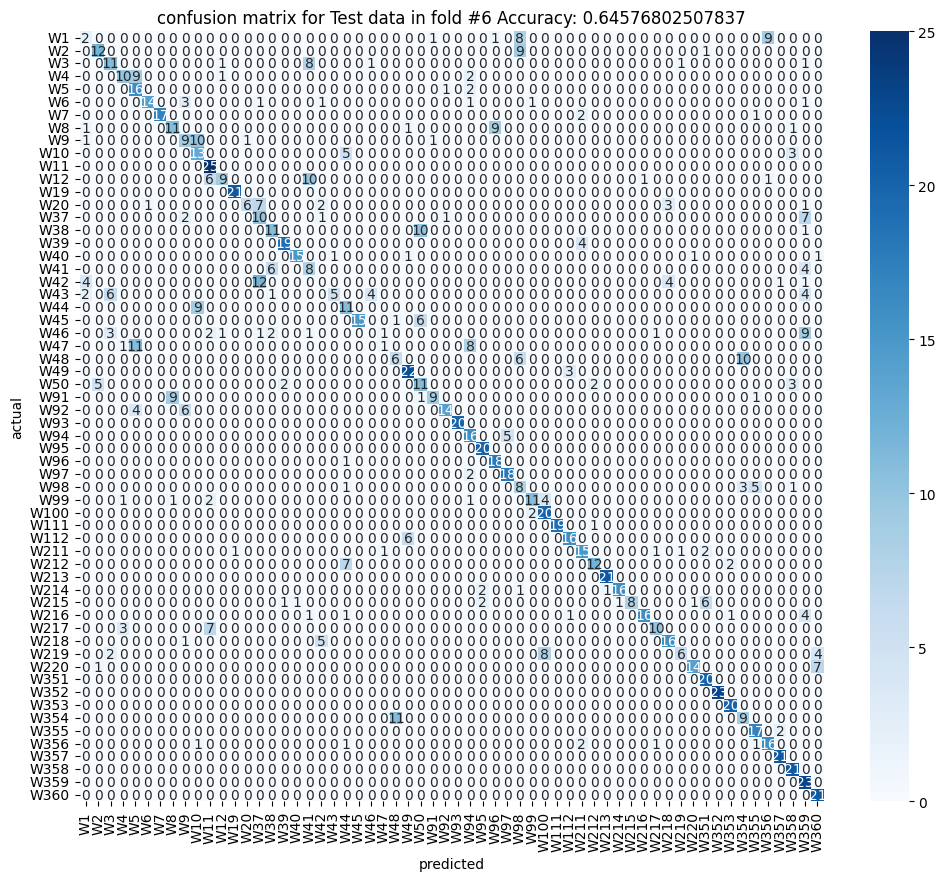

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat= conf_matrixes[bestTest-1]
print('test accuracies: ',test_accuracies, bestTest-1)
print ('validation accuracies: ',all_accuracies)
# average_conf_mat = np.mean(conf_matrixes, axis=0)
# for conf_matrix in conf_matrixes:
#     average_conf_mat +=  conf_matrix
# y_val_true_classes,y_val_pred_classes
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test data in fold #{bestTest} Accuracy: {test_accuracies[bestTest-1]}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

